# PhageHostLearn - v3.2 (Klebsiella)

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both based on language models and HDC
- Combined XGBoost model (for language embeddings) and RF (for HDC embeddings) to make predictions
- Active learning to assess benefits of increasing the training set

## 0 - Libraries and directories

In [56]:
import ast
import math
import subprocess
import numpy as np
import pandas as pd
import learning_utils as lu
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
%matplotlib inline

In [26]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

## 1 - Processing language & HDC embeddings into structured dataframe for training

In [27]:
# construct multi-RBP representations
RBP_embeddings = pd.read_csv(valencia_dir+'/RBP_esm_embeddings.csv')

multi_embeddings = []
names = []
for phage_id in list(set(RBP_embeddings['phage_ID'])):
    rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
    multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
    names.append(phage_id)
    multi_embeddings.append(multi_embedding)
multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

In [28]:
# load hdc matrix to reorder
import ast
hdcf = pd.read_csv(valencia_dir+'/hdc_convolved_features.txt', sep="\t", header=None)
pairs = [ast.literal_eval(i) for i in hdcf.iloc[:,0]]

In [29]:
# construct dataframe for training
loci_embeddings = pd.read_csv(valencia_dir+'/loci_esm_embeddings.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)
features_lan = []
features_hdc = []
labels = []
groups_loci = []
groups_phage = []

for i, accession in enumerate(loci_embeddings['accession']):
    for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
        interaction = interactions.loc[accession][phage_id]
        if math.isnan(interaction) == False: # if the interaction is known
            # language embeddings
            features_lan.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
            
            # hdc embeddings reorder
            pair = (accession, phage_id)
            this_index = pairs.index(pair)
            features_hdc.append(hdcf.iloc[this_index, 1:])
            
            # append labels and groups
            labels.append(int(interaction))
            groups_loci.append(i)
            groups_phage.append(j)
            
features_lan = np.asarray(features_lan)
features_hdc = np.asarray(features_hdc)
print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))
print("Dimensions match?", features_lan.shape[0] == features_hdc.shape[0])

Dimensions match? True
Dimensions match? True


## 2 - LOGOCV with the ensemble <a name="models"></a>

In [30]:
def mean_reciprocal_rank(queries):
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    queries = (np.asarray(r).nonzero()[0] for r in queries)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in queries])

In [31]:
def recallatk(queries, k):
    """
    recall at top K for binary problems. Relevant items should be labeled as 1.
    
    Input: 
    - queries: list of lists of queries that are sorted (i.e. true labels sorted by prediction score)
    - k: the top you want to look at
    """
    recalls_k = [query[:k].count(1) / query.count(1) for query in queries]
    return np.mean(recalls_k)

In [32]:
def marecallatk(queries, kmax):
    """
    mean average recall @ K; computes the average recall@K for values up to kmax and then
    takes the mean over all queries. Relevant items should be labeled as 1.
    """
    average_recalls = []
    for query in queries:
        recalls = [query[:k+1].count(1) / query.count(1) for k in range(kmax)]
        average_recalls.append(np.mean(recalls))
    return np.mean(average_recalls)

In [33]:
def hitratio(queries, k):
    """
    hit ratio for in the first k elements (sorted queries)
    """
    return sum([1 for query in queries if sum(query[:k]) > 0]) / len(queries)

In [34]:
def uninorm(x, y):
    result = (x*y) / (x*y + (1-x)*(1-y))
    return result

In [12]:
# do the LOGOCV
logo = LeaveOneGroupOut()
cpus = 6
scores_lan = []
scores_hdc = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features_lan, labels, groups_loci):
    # get the training and test data
    Xlan_train, Xlan_test = features_lan[train_index], features_lan[test_index]
    Xhdc_train, Xhdc_test = features_hdc[train_index], features_hdc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    ## LANGUAGE EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    ## HDC EMBEDDINGS: RF model
    rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight='balanced', n_jobs=cpus)
    rf.fit(Xhdc_train, y_train)
    score_rf = rf.predict_proba(Xhdc_test)[:,1]
    scores_hdc.append(score_rf)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
# save results
logo_results = pd.DataFrame({'labels': label_list, 'scores_language': scores_lan, 
                             'scores_hdc': scores_hdc})
logo_results.to_csv(results_dir+'/v3.2/ensemble_logocv_results.csv', index=False)

# compute performance
rocaucs = []
praucs = []
rqueries_lan = []
rqueries_hdc = []
rqueries_ens = []
for i in range(200):
    score_lan = scores_lan[i]
    score_hdc = scores_hdc[i]
    score_ens = [uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
    y_test = label_list[i]
    try:
            roc_auc = roc_auc_score(y_test, score_ens)
            rocaucs.append(roc_auc)
            precision, recall, thresholds = precision_recall_curve(y_test, score_ens)
            praucs.append(round(auc(recall, precision), 3))
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            ranked_hdc = [x for _, x in sorted(zip(score_hdc, y_test), reverse=True)]
            ranked_ens = [x for _, x in sorted(zip(score_ens, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            rqueries_hdc.append(ranked_hdc)
            rqueries_ens.append(ranked_ens)
    except:
        pass

In [16]:
# results, part 1
print('ROC AUC: ', np.mean(rocaucs))
print('PR AUC: ', np.mean(praucs))
print('Mean average recall @ K: ', marecallatk(rqueries_ens, 50))

ROC AUC:  0.8202753502742417
PR AUC:  0.5578188976377952
Mean average recall @ K:  0.8040699912510937


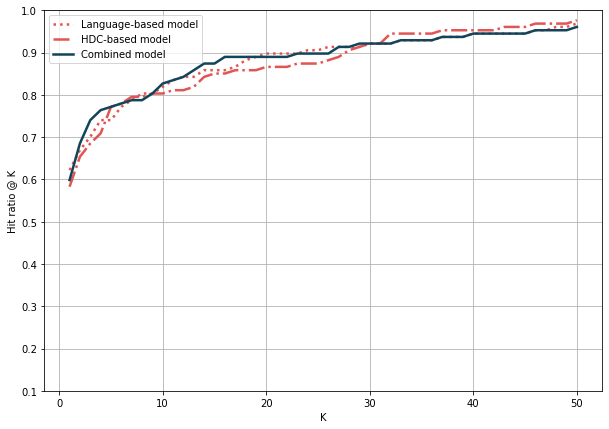

In [23]:
# results, hit ratios @ K
ks = np.linspace(1, 50, 50)
hits_lan = [hitratio(rqueries_lan, int(k)) for k in ks]
hits_hdc = [hitratio(rqueries_hdc, int(k)) for k in ks]
hits_ens = [hitratio(rqueries_ens, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(ks, hits_lan, c='#E15554', linewidth=2.5, ls=':', label='Language-based model')
ax.plot(ks, hits_hdc, c='#E15554', linewidth=2.5, ls='-.', label='HDC-based model')
ax.plot(ks, hits_ens, c='#124559', linewidth=2.5, label='Combined model')
ax.set_xlabel('K')
ax.set_ylabel('Hit ratio @ K')
ax.set_ylim(0.1, 1)
ax.legend()
ax.grid(True)
#fig.savefig(results_dir+'/v3.2/logocv_hitratio.png', dpi=400)
fig.savefig(results_dir+'/v3.2/logocv_hitratio_svg.svg', format='svg', dpi=400)

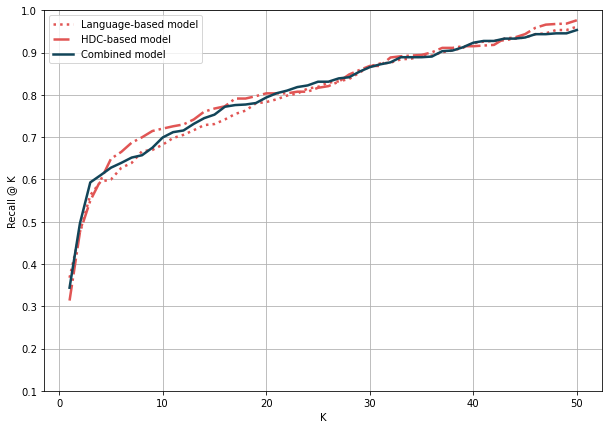

In [24]:
# results, recalls @ K
ks = np.linspace(1, 50, 50)
recalls_lan = [recallatk(rqueries_lan, int(k)) for k in ks]
recalls_hdc = [recallatk(rqueries_hdc, int(k)) for k in ks]
recalls_ens = [recallatk(rqueries_ens, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(ks, recalls_lan, c='#E15554', linewidth=2.5, ls=':', label='Language-based model')
ax.plot(ks, recalls_hdc, c='#E15554', linewidth=2.5, ls='-.', label='HDC-based model')
ax.plot(ks, recalls_ens, c='#124559', linewidth=2.5, label='Combined model')
ax.set_xlabel('K')
ax.set_ylabel('Recall @ K')
ax.set_ylim(0.1, 1)
ax.legend()
ax.grid(True)
#fig.savefig(results_dir+'/v3.2/logocv_recall.png', dpi=400)
fig.savefig(results_dir+'/v3.2/logocv_recall_svg.svg', format='svg', dpi=400)

#### Single-RBP LOOCV

In [37]:
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    phage_test = np.asarray(groups_phage)[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # loop over phage's RBPs
    score_xgb = []
    loci_embedding = X_test[0, :1280] # always the same within a test group
    for phage_index in phage_test:
        # get the correct embeddings
        phage_id = list(multiRBP_embeddings['phage_ID'])[phage_index]
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        
        # make predictions for each single RBP
        rbp_scores = []
        for rbpi in range(rbp_embeddings.shape[0]):
            test_embedding = pd.concat([pd.DataFrame(loci_embedding), rbp_embeddings.iloc[rbpi,:]])
            this_xgb_score = xgb.predict_proba(np.asarray(test_embedding).reshape((1,-1)))[:,1]
            rbp_scores.append(this_xgb_score[0])
                              
        # add max score to the list for AUC computing
        score_xgb.append(max(rbp_scores))
    
    # compute ROC & PR AUC
    try:
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group

        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query) 
    except:
        noauc_scores.append(score_xgb)

    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [38]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
print('top 10 recall: ', recallatk(ranked_queries, 10))
logo_results = pd.DataFrame({'sero': sero_groups, 'rocauc_scores': rocauc_scores, 'prauc_scores': prauc_scores, 
                             'ranked_queries': ranked_queries})
logo_results.to_csv(results_dir+'/v2.3/language_xgb_singlerbp_logocv_results.csv', index=False)

ROC AUC:  0.7785468959224573
PR AUC:  0.3663464566929134
MRR:  0.47427649711853287
top 10 recall:  0.6006061742282215


## 3 - Active learning

1. Randomly select 10% of bacteria for testing
2. Use the other 90% to progressively train HDC model (iteratively increasing training size)
3. Compute the top 1, 3, 5 hit ratio on the  held-out test set
4. Repeat the process 100 times

In [131]:
# 1. Randomly select 10% of groups for testing
repeats = 100
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight='balanced', n_jobs=cpus)
labels = np.asarray(labels)
pbar = tqdm(total=repeats)
hits_1d = {}
hits_3d = {}
hits_5d = {}
cpus = 6

for rep in range(repeats):
    # 1. Randomly select 10% of groups for testing
    hits_1d[rep] = []; hits_3d[rep] = []; hits_5d[rep] = []
    gss = GroupShuffleSplit(n_splits=1, train_size=.9)
    for (train_index, test_index) in gss.split(features_hdc, labels, groups_loci):
        X_train, X_test = features_hdc[train_index], features_hdc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        groups_train = np.asarray(groups_loci)[train_index]
        groups_test = np.asarray(groups_loci)[test_index]

        # 2. Progressively train on the 90% (thus we select the TEST set below)
        group_kfold = GroupKFold(n_splits=9)
        progressive_index = []
        for (train_k, test_k) in group_kfold.split(X_train, y_train, groups_train):
            progressive_index.append(test_k)
            progressive_indices = np.concatenate((progressive_index))
            X_train_progressive = X_train[progressive_indices]
            y_train_progressive = y_train[progressive_indices]

            # HDC RF model
            rf.fit(X_train_progressive, y_train_progressive)

            # 3. Compute the top 1, 3, 5 hit ratio on the held-out test set
            scores = rf.predict_proba(X_test)[:,1]
            rqueries = []
            # account for multiple bacteria in test set by looping over each one
            for testgroup in set(groups_test):
                group_scores = scores[groups_test == testgroup]
                group_y = y_test[groups_test == testgroup]
                # only add query if there's actually a positive to find
                if sum(group_y) > 0:
                    ranked_query = [x for _, x in sorted(zip(group_scores, group_y), reverse=True)]
                    rqueries.append(ranked_query)
            hits_1d[rep].append(hitratio(rqueries, 1))
            hits_3d[rep].append(hitratio(rqueries, 3))
            hits_5d[rep].append(hitratio(rqueries, 5))

    # pbar update
    pbar.update(1)

pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [133]:
hitratio_1 = []; hitratio_3 = []; hitratio_5 = []
for i in range(9):
    hrs_1 = [hits_1d[key][i] for key in hits_1d.keys()]
    hrs_3 = [hits_3d[key][i] for key in hits_3d.keys()]
    hrs_5 = [hits_5d[key][i] for key in hits_5d.keys()]
    hitratio_1.append(np.mean(hrs_1))
    hitratio_3.append(np.mean(hrs_3))
    hitratio_5.append(np.mean(hrs_5))

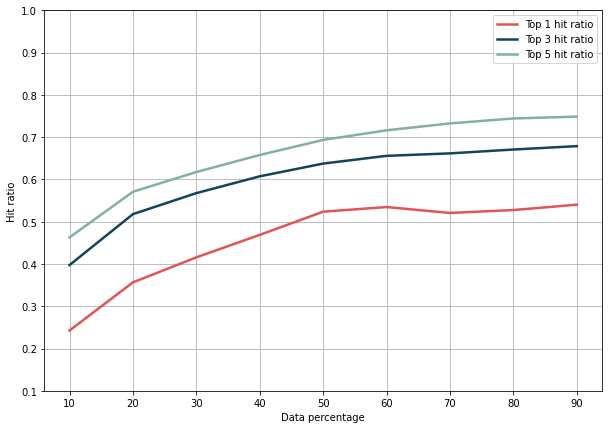

In [136]:
fig, ax = plt.subplots(figsize=(10,7))
percentage = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ax.plot(percentage, hitratio_1, c='#E15554', linewidth=2.5, label='Top 1 hit ratio')
ax.plot(percentage, hitratio_3, c='#124559', linewidth=2.5, label='Top 3 hit ratio')
ax.plot(percentage, hitratio_5, c='#81B29A', linewidth=2.5, label='Top 5 hit ratio')
ax.set_xlabel('Data percentage')
ax.set_ylabel('Hit ratio')
ax.set_ylim(0.1, 1)
ax.legend()
ax.grid(True)
fig.savefig(results_dir+'/v3.2/hdc_convolved_activelearning_groupshuffle.png', dpi=400)
fig.savefig(results_dir+'/v3.2/hdc_convolved_activelearning_groupshuffle_svg.svg', format='svg', dpi=400)